<a href="https://colab.research.google.com/github/PiotrZam/AdvancedAI/blob/main/Coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 1: Dataset

Sentiment analysis of financial news has always attracted a lot of attention. It has many applications but the two main ones include news summary and financial forecasting, both of which are of great interest to both companies in the financial sector and individuals, eg investors.

The task performed in this coursework will involve sentiment analysis of the Forex Market news articles. The analysis will be performed using ordinal Multi Class Classification, where the main input feature will be the title of the article.
<br><br>
The chosen dataset contains news relevant to the following Forex currency pairs: AUDUSD, EURCHF, EURUSD, GBPUSD, and USDJPY. It consists of over 2200 rows. The data was collected from reputable sources using web scraping techniques, and then manually annotated to include the sentiment of each article, and its likely effect on the price of that currency pair (Positive/Neutral/Negative).

The dataset includes both titles and bodies of the articles in separate columns. It also includes the currency pair affected, and metadata such as date, author, URL.

Initial exploration shows that the dataset has no null values, and is mostly balanced (except poor representation of the EURCHF pair). Overall, the dataset  is an excellent candidate for the described task.

# Import the libraries

In [1]:
## Most of the libraries used. Keeping them here for cleanliness

import pandas as pd
import numpy as np
import re

# Keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Concatenate, Dense, Dropout, Flatten, Conv1D, MaxPooling1D

#Word2Vec
import gensim
from gensim.models import Word2Vec
import gensim.downloader as api
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models.callbacks import CallbackAny2Vec

#Preprocessing
import nltk #import the natural language toolkit
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords') #download the nltk package for stopwords

#sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from gensim.models import Word2Vec
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
import scipy.sparse as sp
from sklearn.preprocessing import LabelEncoder


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load the dataset, perform initial exploration and modifcations

In [2]:
#Load the dataset
df = pd.read_csv('/content/drive/MyDrive/RGU_2024 25/AdvancedAI/Coursework/sentiment_annotated_with_texts.csv')


In [3]:
df.head(5)

,published_at,ticker,true_sentiment,title,author,url,source,text,finbert_sentiment,finbert_sent_score
0,2023-01-12 07:47:00,EURCHF,Positive,Euro to benefit from the ECBs pronounced hawki...,FXStreet Insights Team,https://www.fxstreet.com/news/euro-to-benefit-...,FX Street,The Euro was able to appreciate particularly s...,Positive,0.85
1,2023-01-12 10:34:00,EURCHF,Positive,EURCHF Trend higher may remain in place – ING,FXStreet Insights Team,https://www.fxstreet.com/news/eur-chf-trend-hi...,FX Street,EUR/CHF yesterday broke above 1.00. Economists...,Positive,0.51
2,2023-01-12 11:40:00,EURCHF,Neutral,Does a jump in EURCHF point to a break above 1...,FXStreet Insights Team,https://www.fxstreet.com/news/does-a-jump-in-e...,FX Street,EUR/CHF vaults parity for the first time since...,Neutral,0.37
3,2023-01-12 15:32:00,EURCHF,Positive,EURCHF could extend its advance back to levels...,FXStreet Insights Team,https://www.fxstreet.com/news/eur-chf-could-ex...,FX Street,EUR/CHF climbs back above parity. Economists a...,Positive,0.64
4,2023-01-13 11:37:00,EURCHF,Positive,EURCHF to head higher towards 10130 and projec...,FXStreet Insights Team,https://www.fxstreet.com/news/eur-chf-to-head-...,FX Street,EUR/CHF has broken out above the sideways rang...,Positive,0.83


In [4]:
# Fiberts accuracy
## From the dataset: output to compare with the ccuracy of our algorithms.
count_diff = (df['finbert_sentiment'] == df['true_sentiment']).sum() / len(df)
print('Finberts accuracy: ')
print(count_diff)

# Finberts accuracy:  0.5617634220864252
# Seems very low!

Finberts accuracy: 
0.5617634220864252


In [5]:
# Drop the columns we don't need:
df = df.drop(columns=['published_at', 'author', 'url', 'source', 'finbert_sentiment', 'finbert_sent_score'])

# Rename the currency pair column
df = df.rename(columns={'ticker': 'pair'})

# represent the sentiment in integers
df['true_sentiment_int'] = df['true_sentiment'].map({'Negative': 0, 'Neutral': 1, 'Positive': 2}).values

#Encode the pair column using LabelEncoder
pairs_encoder = LabelEncoder()
df['encoded_pair'] = pairs_encoder.fit_transform(df['pair'])

In [6]:
df.head(5)

,pair,true_sentiment,title,text,true_sentiment_int,encoded_pair
0,EURCHF,Positive,Euro to benefit from the ECBs pronounced hawki...,The Euro was able to appreciate particularly s...,2,1
1,EURCHF,Positive,EURCHF Trend higher may remain in place – ING,EUR/CHF yesterday broke above 1.00. Economists...,2,1
2,EURCHF,Neutral,Does a jump in EURCHF point to a break above 1...,EUR/CHF vaults parity for the first time since...,1,1
3,EURCHF,Positive,EURCHF could extend its advance back to levels...,EUR/CHF climbs back above parity. Economists a...,2,1
4,EURCHF,Positive,EURCHF to head higher towards 10130 and projec...,EUR/CHF has broken out above the sideways rang...,2,1


In [7]:
# Check for nulls
nulls = df.isnull().sum()
print(nulls)

pair                  0
true_sentiment        0
title                 0
text                  0
true_sentiment_int    0
encoded_pair          0
dtype: int64


In [8]:
# Get unique values from the 'sentiment' and 'pair' columns:
unique_values = df[['pair', 'true_sentiment']].apply(lambda x: x.unique(), axis=0)
print(unique_values)

pair              [EURCHF, USDJPY, GBPUSD, EURUSD, AUDUSD]
true_sentiment               [Positive, Neutral, Negative]
dtype: object


In [9]:
# Check class distribution
df['true_sentiment'].value_counts()

,count
true_sentiment,
Neutral,815
Positive,767
Negative,709


In [10]:
# Check distribution among currency pairs
df['pair'].value_counts()

# Note that EURCHF has poor representation but other than that it looks fine

,count
pair,
EURUSD,758
GBPUSD,518
USDJPY,499
AUDUSD,461
EURCHF,55


In [11]:
from nltk.tokenize import sent_tokenize

# Initial preprocessing: perform substitutions to increase model's accuracy

df['title'] = df['title'].replace(r'(?i)dollar', ' USD ', regex=True)
df['title'] = df['title'].replace(r'(?i)euro', ' EUR ', regex=True)
df['title'] = df['title'].replace(r'(?i)frank', ' CHF ', regex=True)
df['title'] = df['title'].replace(r'(?i)yen', ' JPY ', regex=True)
df['title'] = df['title'].replace({'\$': ' USD ', '£': ' GBP ', '€': ' EUR ', '¥': ' JPY '}, regex=True)
df['title'] = df['title'].replace({'EUR/CHF': ' EURCHF ', 'USD/JPY': ' USDJPY ', 'GBP/USD': ' GBPUSD ', 'EUR/USD': ' EURUSD ', 'AUD/USD': ' AUDUSD '}, regex=True)
df['title'] = df['title'].replace({'eur/chf': ' EURCHF ', 'usd/jpy': ' USDJPY ', 'gbp/usd': ' GBPUSD ', 'eur/usd': ' EURUSD ', 'aud/usd': ' AUDUSD '}, regex=True)
df['title'] = df['title'].replace('%', ' percent ', regex=True)
df['title'] = df['title'].replace(r'\+/-', ' ', regex=True)
df['title'] = df['title'].replace(r'\+', ' plus ', regex=True)
df['title'] = df['title'].replace(r'-(?=\d)', ' minus ', regex=True)
df['title'] = df['title'].replace('/', ' ', regex=True)
df['title'] = df['title'].replace('  ', ' ', regex=True)

df['text'] = df['text'].replace(r'(?i)dollar', ' USD ', regex=True)
df['text'] = df['text'].replace(r'(?i)euro', ' EUR ', regex=True)
df['text'] = df['text'].replace(r'(?i)frank', ' CHF ', regex=True)
df['text'] = df['text'].replace(r'(?i)yen', ' JPY ', regex=True)
df['text'] = df['text'].replace({'\$': ' USD ', '£': ' GBP ', '€': ' EUR ', '¥': ' JPY '}, regex=True)
df['text'] = df['text'].replace({'EUR/CHF': ' EURCHF ', 'USD/JPY': ' USDJPY ', 'GBP/USD': ' GBPUSD ', 'EUR/USD': ' EURUSD ', 'AUD/USD': ' AUDUSD '}, regex=True)
df['text'] = df['text'].replace({'eur/chf': ' EURCHF ', 'usd/jpy': ' USDJPY ', 'gbp/usd': ' GBPUSD ', 'eur/usd': ' EURUSD ', 'aud/usd': ' AUDUSD '}, regex=True)
df['text'] = df['text'].replace('%', ' percent ', regex=True)
df['text'] = df['text'].replace(r'\+/-', ' ', regex=True) # +/- => remove
df['text'] = df['text'].replace(r'\+', ' plus ', regex=True)
df['text'] = df['text'].replace(r'-(?=\d)', ' minus ', regex=True) # minus with number eg -0.7 => minus
df['text'] = df['text'].replace('/', ' ', regex=True)
df['text'] = df['text'].replace('  ', ' ', regex=True) ## Replace any double whitespaces created by the lines above with single one
df['text'] = df['text'].replace('"', ' ', regex=True)


# Add a columns with a flag if a given currency pair is in the title
df['pair_in_title'] = df.apply(lambda row: int(pairs_encoder.inverse_transform([row['encoded_pair']])[0] in row['title']), axis=1)



# Section 2: Representation Learning

In this task 2 types of Text Representation are being used: TF-IDF (Term Frequency-Inverse Document Frequency) and Word2Vec, in order to compare their efficiency. TF-IDF was used by KNN and SVM models, whereas Word2Vector by SVM and MLP.

Word2Vec model was trained on the article bodies (rather than titles), since they had more data, which led to better accuracy. During training each article sentence was considered separately from the rest of the article (although both approaches were tested). The model was using CBoW rather than Skipgram.

TF-IDF was trained on article titles, since using article bodies did not improve accuracy and was more resource intensive.

Additionally, the TF-IDF/Word2Vec vectors were combined with other feature representations before the classification took place.   
<br>
Surprisingly, TF-IDF method in this task achieved slightly better results than context-aware Word2Vec. TF-IDF is a statistics-based text representation method and it doesn't capture the semantic meaning of the text. It calculates a vector for a term in each document based on:
*  Term Frequency: how often a term appears in a specific document
* Inverse Document Frequency: how often a term appears in all the documents

As this task proves, TF-IDF can still be relevant and somewhat effective in simple classification tasks where context knowledge isn't mandatory, or the dataset is small.

# Preprocess the titles and article bodies

In [12]:
## Data preprocessing class
### This class will be used both by the pipeline (TF-IDF), and called directly from the code (for Word2Vec) preprocessings

# It has 'isForTFIDF' flag which determines how it should behave, but at the moment the behavviour is pretty similar, except that for TF-IDF it bundles the elements together so that it's ready for CountVectorizer.
# For W2V it's always called by lambda functions

from sklearn.base import BaseEstimator, TransformerMixin

class Text_Preprocessor(BaseEstimator, TransformerMixin):

    def __init__(self, isForTFIDF=True):
      self.isForTFIDF = isForTFIDF

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
      # Handle diffeently if it's part of the TF-IDF pipeline - it will be subject to further processing by CountVec
      if self.isForTFIDF == True:
        prep_text = []
        for x in X:
              token_text = word_tokenize(x)
              normd_text = [token for token in token_text if re.match(r'^[A-Za-z]+$', token)] # Remove special characters  and numbers # [A-Za-z0-9]

              swr_text = [token for token in normd_text if token not in stopwords.words('english')]
              stemmer = SnowballStemmer("english")
              prep_text += [[stemmer.stem(word) for word in swr_text]]

        prep_sentences = [" ".join(sentence) for sentence in prep_text]
        return prep_sentences

      #Word2Vec - to be used with lambda expressions
      else:
        token_text = word_tokenize(X) #tokenize the document
        normd_text = [token for token in token_text if re.match(r'^[A-Za-z]+$', token)] # Remove special characters and numbers
        swr_text = [token for token in normd_text if token not in stopwords.words('english')]

        stemmer = SnowballStemmer("english")
        prep_text = [stemmer.stem(word) for word in swr_text]
        return prep_text


In [13]:
# Preprocess Article Titles for Word2Vec and save in the dataframe
preprocessor_W2V = Text_Preprocessor(isForTFIDF=False)

processed_titles_W2V = df['title'].apply(
    lambda title: preprocessor_W2V.transform(title)
    )
#print(processed_titles_W2V)
df['processed_titles'] = processed_titles_W2V


In [14]:
# Preprocess Article Body and save in the dataframe - It will be used to train the  Word2Vec model
# We'll train the mode from the body of the articles, since that is way more data than titles

# First tokenize each article into sentences
article_sentences = df['text'].apply(lambda article: sent_tokenize(article.lower()))  # tokenize articles into sentences

preprocessor_Art = Text_Preprocessor(isForTFIDF=False)

#Each sentence is a separate list of tokens
df['preprocessed_sentences'] = article_sentences.apply(
    lambda sentences: [preprocessor_Art.transform(sentence) for sentence in sentences]
)

# # Visual check
# pd.set_option('display.max_colwidth', None)
# print(df['preprocessed_sentences'])

In [15]:
#########################################################################################
## !!! This whole code section is here just for initial testin, not to train the Word2Vec model in each fold. It is now being executed in each fold to prevent data leaking between test and train subsets !!!

## (even though Word2Vec model is trained on news bodies only,  not on titles so any leaking would be quite limited anyway, and keeping it here had no impact on accuracy. Still it is a good practice !)

# # # Data from article bodies is preprocessed now. W2V model can now be trained on it

# from gensim.test.utils import common_texts, get_tmpfile
# from gensim.models import Word2Vec
# from gensim.models.callbacks import CallbackAny2Vec

# # Each sentence from all the articles is a separate row (circca 23.000 of them)
# flattened_sentences = [sentence for article in df['preprocessed_sentences'] for sentence in article]

# ########### [!! Only for testing !!]
# # # Sentences from each article are combined - Each article is a list of tokens from all the sentences in it. (2.200 articles)
# # flattened_sentences = df['preprocessed_sentences'].apply(lambda article: [token for sentence in article for token in sentence])
# #####

# # Declare and train the W2V model
# w2v_model = Word2Vec(vector_size=300, window=7, min_count=1, workers=4, sg=0, compute_loss=True) # sg: 0 for CBoW, 1 for Skipgram
# w2v_model.build_vocab(flattened_sentences, update=False)
# w2v_model.train(corpus_iterable=flattened_sentences, total_examples=len(flattened_sentences), epochs=50)

# # # Perform checks:
# # similar_words = w2v_model.wv.most_similar('eurusd', topn=20)
# # print(similar_words)

#########################################################################################


# Declare other functions used in the pipelines

In [16]:
# A function that will create the W2V vectors
def word2vec_rep(inputSentence, w2v_model):
  embs = [w2v_model.wv[inputWord] for inputWord in inputSentence if inputWord in w2v_model.wv.index_to_key]
  sent_emb = np.mean(np.array(embs), 0)
  return sent_emb

## Reshape function: It will be used to combine vector from text representation with other added features: (encoded currency pair, pair_in_title flag)
def reshape_vector(title_vec, pair, pair_in_title):
    reshaped_pair = pair.to_numpy().reshape(-1, 1)
    reshaped_pair_in_title = pair_in_title.to_numpy().reshape(-1, 1)
    if sp.issparse(title_vec):
         title_vec = title_vec.toarray()
    return np.hstack([title_vec, reshaped_pair, reshaped_pair_in_title])
    #return title_vec

# Section 3: Algorithms

In total, three algorithms were used in this task:
* k-Nearest Neighbour (kNN)
* Support Vector Machine (SVM)
* Multi-Layer Perceptron (MLP)


kNN model used TF-IDF as the text representation, MLP - Word2Vec and SVM both approaches (one SVM model for each of them).
<br><br>

**SVM:** A supervised machine learning algorithm widely used for classification and regression tasks. It attempts to find a hyperplane that separates data points belonging to different classes, eg. in a two dimesional space, it will simply be a line.

Support Vectors are the data points closest to the hyperplane. They are used to determine the margin, ie the distance between the hyperplane and Support Vectors. SVM aims to maximise the margin, since the larger the margin, the better the algorithms is at classifying the data. If the data cannot be linearly separated, SVM uses kernel functions to create a representation of the data in a higher dimension and then find the hyperplane.

SVMs can be very efficient for simple classification tasks, especially in high dimensional spaces. They are also memory-efficient and robust to overfitting. However, they might not perform very well for large datasets, or datasets that have a lot of noise, and are sensitive to the choice of the kernel function.

<br>

**MLP:** A type of Artificial Neural Network. It's made of mutiple layers of neurons: input, output and at least one hidden layer. It receives input in the form of a numerical vector, where the size of the input layer corresponds to the size of the vector. The input data is then passed on by the neurons in each consecutive layer, and the output layer produces the final output. For a simple classification task it is a set of probabilities that data belongs to certain classes.

The neurons from the neighbouring layers are interconnected, and every connection between neurons has a weight which determines the importance of the input signal. Additionally, each neuron has a bias that helps adjust its output. The output of each neuron (except for the input layer) is calculated by applying an activation function to the weighted sum of its inputs plus bias, and then passed to neurons in the next layer.

Once the data has gone through all the layers (forward propagation), the loss function calculates how inaccurate the predictions were. Next, during backpropagation the weights and biases responsible for the loss are identified and then updated. This process is repeated for a number of iterations (epochs) until the loss is minimal and the model finds the optimal set of weights and biases.

MLPs can recognise complex, non-linear patterns and relationships between features. They are also fairly flexible and can handle different data types, eg. time series. They are, however, prone to overfitting, and require careful tuning. They also require large datasets of labelled data to perform well. On small to medium datasets simple machine learning algorithms (eg SVM) tend to perform better. This was also confirmed by the results of this task, in which SVM outperformed MLP.


# Hypertuning ML/NN models: discovering the optimal parameters (doesn't need to be run)

In [23]:
## Prepare for hypertuning.
## We'll use GridSearch To hypertune (find the best performing parameters) for our selected models.

# First prepare the data:

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Features
X = df[['processed_titles', 'encoded_pair', 'title', 'preprocessed_sentences', 'pair_in_title']]

# Labels
Y = df['true_sentiment_int']

# Create the train and test sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

x_train_articles = x_train['preprocessed_sentences']
x_train_title_raw = x_train['title']
x_train_title = x_train['processed_titles']
x_train_pair = x_train['encoded_pair']
x_train_pair_in_title = x_train['pair_in_title']

x_test_articles = x_test['preprocessed_sentences']
x_test_title_raw = x_test['title']
x_test_title = x_test['processed_titles']
x_test_pair = x_test['encoded_pair']
x_test_pair_in_title = x_test['pair_in_title']

#--------------------- TF-IDF:
pipe_TFIDF = Pipeline([
  ('prep', Text_Preprocessor(True)),
  ('count', CountVectorizer()), # max_df=0.9, ngram_range=(1, 2)
  ('rep', TfidfTransformer(sublinear_tf=True))
  ])


# Get TF-IDF text representation
x_train_title_TFIDF = pipe_TFIDF.fit_transform(x_train_title_raw)
x_test_title_TFIDF = pipe_TFIDF.transform(x_test_title_raw)

# x_train_combined_TFIDF = reshape_vector(x_train_title_TFIDF, x_train_pair)
x_train_combined_TFIDF = reshape_vector(x_train_title_TFIDF, x_train_pair, x_train_pair_in_title)
x_test_combined_TFIDF = reshape_vector(x_test_title_TFIDF, x_test_pair, x_test_pair_in_title)

#--------------------- Word2Vec
# Get word embeddings for each title
x_train_title_vec = [word2vec_rep(instance, w2v_model) for instance in x_train_title]
x_test_title_vec = [word2vec_rep(instance, w2v_model) for instance in x_test_title]

# Combine pair info with the word vectors
x_train_combined = reshape_vector(x_train_title_vec, x_train_pair, x_train_pair_in_title)
x_test_combined = reshape_vector(x_test_title_vec, x_test_pair, x_test_pair_in_title)
print(x_test_combined.shape)

print(y_train.shape)



(1832, 5) (459, 5) (1832,) (459,)
(459, 302)
(1832,)


In [29]:
############## KNN Hypertuning


# Set up parameters to test
param_grid = {
        'n_neighbors': [19, 21, 23, 25],
        'weights': ['distance'],
        'metric': ['cosine'],
        'algorithm': ['auto']
    }

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, n_jobs=-1, verbose=2)

grid_search.fit(x_train_combined_TFIDF, y_train)
knn_predictions = grid_search.predict(x_test_combined_TFIDF)

knn_acc = accuracy_score(knn_predictions, y_test)

# Output the best results:
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
print("KNN  Accuracy:", knn_acc)

#######################
# Fitting 5 folds for each of 144 candidates, totalling 720 fits
# Best Parameters: {'algorithm': 'auto', 'metric': 'cosine', 'n_neighbors': 15, 'weights': 'distance'}
# Best Score: 0.5660487485296526
# KNN  Accuracy: 0.5490196078431373

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Parameters: {'algorithm': 'auto', 'metric': 'cosine', 'n_neighbors': 21, 'weights': 'distance'}
Best Score: 0.57750331293459
KNN  Accuracy: 0.5773420479302832


In [27]:
######### SVM : Hypertuning

# Set up parameters to test
param_grid = {
        'C': [0.5, 1, 3, 5, 7],
        'gamma': ['scale'],
        'kernel': ['rbf']
    }

svm = SVC()
grid_search = GridSearchCV(svm, param_grid, cv=5, n_jobs=-1, verbose=2)

grid_search.fit(x_train_combined, y_train)
svm_predictions = grid_search.predict(x_test_combined)

svm_acc = accuracy_score(svm_predictions, y_test)

# Output the best results:
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
print("SVM Accuracy:", svm_acc)

############################################################
# Best Parameters: {'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}
# Best Score: 0.6309986450469767
# SVM Accuracy: 0.6405228758169934

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Parameters: {'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}
Best Score: 0.6239052426259287
SVM Accuracy: 0.6405228758169934


In [28]:
######### SVM with TF-IDF : Hypertuning

# Set up parameters to test
param_grid = {
        'C': [1, 3, 5, 7],
        'gamma': ['scale'],
        'kernel': ['linear']
    }

svm2 = SVC()
grid_search = GridSearchCV(svm2, param_grid, cv=3, n_jobs=-1, verbose=2)

grid_search.fit(x_train_combined_TFIDF, y_train)
svm2_predictions = grid_search.predict(x_test_combined_TFIDF)

svm2_acc = accuracy_score(svm2_predictions, y_test)

# Output the best results:
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
print("SVM TF-IDF Accuracy:", svm2_acc)

############################################################
# Fitting 5 folds for each of 20 candidates, totalling 100 fits
# Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
# Best Score: 0.6430324146454043
# SVM TF-IDF Accuracy: 0.6666666666666666

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best Score: 0.6386582955470294
SVM TF-IDF Accuracy: 0.6579520697167756


In [30]:

########## MLP Hypertuning

from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

param_grid = {
    'hidden_layer_sizes': [(200,), (200, 50)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.01],
    'learning_rate': ['constant'],
    'batch_size' : [32]
}


mlp = MLPClassifier(max_iter=200)

grid_search = GridSearchCV(mlp, param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the training set
grid_search.fit(x_train_combined, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_


mlp_predictions = grid_search.predict(x_test_combined)
mlp_acc = accuracy_score(y_test, mlp_predictions)

# Output the best results:
print("Best Parameters:", best_params)
print("Best Score (CV):", best_score)
print("MLP Test Accuracy:", mlp_acc)


# Fir the testing set
grid_search.fit(x_train_combined, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_


mlp_predictions = grid_search.predict(x_test_combined)
mlp_acc = accuracy_score(y_test, mlp_predictions)

############################################################
# Fitting 5 folds for each of 108 candidates, totalling 540 fits
# Best Parameters: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (200,), 'learning_rate': 'constant', 'solver': 'adam'} # best batch size: 32
# Best Score (CV): 0.6255564985631542
# MLP Test Accuracy: 0.6187363834422658


Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Parameters: {'activation': 'relu', 'alpha': 0.01, 'batch_size': 32, 'hidden_layer_sizes': (200, 50), 'learning_rate': 'constant', 'solver': 'adam'}
Best Score (CV): 0.6075400902309376
MLP Test Accuracy: 0.6187363834422658
Fitting 5 folds for each of 2 candidates, totalling 10 fits


# Training the model

In [19]:
## We know what parameters are likely to be effective. Now we can actually train the mode


# TF-IDF pipeline:
# We stop at text representation since we'll need to combine vectors with pair

pipe_TFIDF = Pipeline([
  ('prep', Text_Preprocessor(True)),
  ('count', CountVectorizer()),   # Parameters from testing (not used): max_df=0.9, ngram_range=(1, 2)
  ('rep', TfidfTransformer(sublinear_tf=True))
  ])

#################### [!! Only for testing !!]

# Only for teting: If we were to train TFIDF on body data rather than just titles (body data: sentences isolated from the rest of the article)
# # Splits text into sentences
# def split_text_into_sentences(text):
#     sentences = re.split(r'(?<=\.)\s+|\!(?=\s)|\?(?=\s)', text)
#     return sentences

# text_split = df['text'].apply(split_text_into_sentences)
# flattened_sentences = [sentence for article in text_split for sentence in article]
# pipe_TFIDF.fit(flattened_sentences)

# We'll also need to changed x_train_title_TFIDF from 'fit_transform' to 'transform' below
# Note that it's also being trained on the body data from ALL articles (not just the test ones), which could potentially lead to slightly higher results than in reality.
##################

# Declare arrays for scores
knn_score = []
knn_f1_score = []
mlp_score = []
mlp_f1_score = []
svm_score = []
svm_f1_score = []
svm2_score = []
svm2_f1_score = []

# Features
X = df[['processed_titles', 'encoded_pair', 'title', 'preprocessed_sentences', 'pair_in_title', 'text']]

# Labels
Y = df['true_sentiment_int']


kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=None) ## Shuffle each time
## Cross validation: split into training and testing set and run the loop
for train, test in kf.split(X, Y):

    print('--------------Next Fold-----------')
    x_train, x_test = X.iloc[train], X.iloc[test]
    y_train, y_test = Y.iloc[train], Y.iloc[test]

    x_train_articles = x_train['preprocessed_sentences']
    x_train_title_raw = x_train['title']
    x_train_title = x_train['processed_titles']
    x_train_pair = x_train['encoded_pair']
    x_train_pair_in_title = x_train['pair_in_title']

    x_test_articles = x_test['preprocessed_sentences']
    x_test_title_raw = x_test['title']
    x_test_title = x_test['processed_titles']
    x_test_pair = x_test['encoded_pair']
    x_test_pair_in_title = x_test['pair_in_title']

    # print('T:::')
    # print(len(x_train_title_vec))
    # print(x_train_title_vec)
    # #print(x_train_title_raw.shape)
    # print(x_train_pair_in_title.shape)

    # print(len(x_test_title_vec))
    # #print(x_test_title_raw.shape)
    # print(x_test_pair_in_title.shape)

    ################################## Train the Word2Vec model on News Articles data
    # flatten before passing to Word2Vec model
    # Each sentence from all the articles is a separate row (circca 23.000 of them)
    flattened_sentences = [sentence for article in x_train_articles for sentence in article]

    # #  [!! Only for testing: Use titles this time !!]
    # flattened_sentences =  x_train['processed_titles'].tolist()
    # #print(flattened_sentences)

    # Declare and train the W2V model
    w2v_model = Word2Vec(vector_size=300, window=7, min_count=1, workers=4, sg=0, compute_loss=True)
    w2v_model.build_vocab(flattened_sentences, update=False)
    #print("Vocabulary size:", len(w2v_model.wv))
    w2v_model.train(corpus_iterable=flattened_sentences, total_examples=len(flattened_sentences), epochs=50)
    ## It might take a while to train it in each fold with 50 epochs... We are doing it to ensure that there is no data leaking.
    ## Even though accuracy doesn't change compared to training it on all the articles outside this loop, since we implement the Word2Vec model only on titles (and train it on article bodies)

    ###################################### Feature Extraction:

    #--------------------- TF-IDF:
    # Get TF-IDF text representation

    x_train_title_TFIDF = pipe_TFIDF.fit_transform(x_train_title_raw)
    #x_train_title_TFIDF = pipe_TFIDF.transform(x_train_title_raw)  # Only if training TF-IDF on article bodies
    x_test_title_TFIDF = pipe_TFIDF.transform(x_test_title_raw)

    x_train_combined_TFIDF = reshape_vector(x_train_title_TFIDF, x_train_pair, x_train_pair_in_title)
    x_test_combined_TFIDF = reshape_vector(x_test_title_TFIDF, x_test_pair, x_test_pair_in_title)

    #--------------------- Word2Vec
    # Get word embeddings for each title
    x_train_title_vec = [word2vec_rep(instance, w2v_model) for instance in x_train_title]
    x_test_title_vec = [word2vec_rep(instance, w2v_model) for instance in x_test_title]


    # print(len(x_train_title_vec))
    # print(x_train_pair.shape)
    # print(x_train_pair_in_title.shape)
    #print('Length of x_train_title_vec: ' + str(len(x_train_title_vec[0])))

    # Combine pair info with the word vectors
    x_train_combined = reshape_vector(x_train_title_vec, x_train_pair, x_train_pair_in_title)
    x_test_combined = reshape_vector(x_test_title_vec, x_test_pair, x_test_pair_in_title)

    #print('Length of x_train_combined: ' + str(len(x_train_combined[0])))

    ############################################ Training Models

    # # --------------------- kNN Model

    kNN = KNeighborsClassifier(
        n_neighbors=21, # 13
        weights='distance',
        metric='cosine',
        algorithm='auto'
    )
    kNN.fit(x_train_combined_TFIDF, y_train)
    knn_predictions = kNN.predict(x_test_combined_TFIDF)

    knn_acc = accuracy_score(knn_predictions, y_test)
    knn_score.append(knn_acc)

    knn_f1 = f1_score(y_test, knn_predictions, average='weighted')
    knn_f1_score.append(knn_f1)

    print('KNN SCore:' + str(knn_acc))

    # ---------------------------- MLP Model

    mlp = MLPClassifier(
        hidden_layer_sizes=(200,),      # One hidden layer with 200 neuorns
        activation='relu',              # relu activation function
        solver='adam',                  # Adam optimiser
        alpha=0.01,
        batch_size=32,
        max_iter=50,                   # Train for max 50 iterations
        learning_rate='constant',
        early_stopping=True,            # Implmenting early stopping to prevent overfitting
        n_iter_no_change=5             # Number of iterations without improvement before early stopping
    )

    # Train and get results
    mlp.fit(x_train_combined, y_train)
    mlp_predictions = mlp.predict(x_test_combined)
    mlp_acc = accuracy_score(mlp_predictions, y_test)
    mlp_score.append(mlp_acc)

    print('MLP SCore:' + str(mlp_acc))

    mlp_f1 = f1_score(y_test, mlp_predictions, average='weighted')
    mlp_f1_score.append(mlp_f1)

    # ------------------------------- SVM Model:

    svm = SVC(kernel='rbf', C=5, gamma='scale')

    # Train and get results:
    svm.fit(x_train_combined, y_train)
    svm_predictions = svm.predict(x_test_combined)

    svm_acc = accuracy_score(svm_predictions, y_test)
    svm_score.append(svm_acc)

    print('SVM SCore:' + str(svm_acc))

    svm_f1 = f1_score(y_test, svm_predictions, average='weighted')
    svm_f1_score.append(svm_f1)

    # ------------------------------- SVM2 (TF-IDF) Model:

    svm2 = SVC(kernel='linear', C=1, gamma='scale')

    # Train and get results:
    svm2.fit(x_train_combined_TFIDF, y_train)
    svm2_predictions = svm2.predict(x_test_combined_TFIDF)

    svm2_acc = accuracy_score(svm2_predictions, y_test)
    svm2_score.append(svm2_acc)

    svm2_f1 = f1_score(y_test, svm2_predictions, average='weighted')
    svm2_f1_score.append(svm2_f1)

    print('SVM TFIDF SCore:' + str(svm2_acc))

############################################ Outputting Results
print('\########################################')
print('\nResults: ')

# Print the results for different models
print("kNN Accuracy:", np.mean(knn_score))
print("MLP Accuracy:", np.mean(mlp_score))
print("SVM Accuracy:", np.mean(svm_score))
print("SVM with TFIDF Accuracy:", np.mean(svm2_score))

print('\nF1 Scores: ')
print("kNN F1:", np.mean(knn_f1_score))
print("MLP F1:", np.mean(mlp_f1_score))
print("SVM F1:", np.mean(svm_f1_score))
print("SVM with TFIDF F1:", np.mean(svm2_f1_score))

print('\########################################')


--------------Next Fold-----------
KNN SCore:0.5642701525054467
MLP SCore:0.6013071895424836
SVM SCore:0.6318082788671024
SVM TFIDF SCore:0.6492374727668845
--------------Next Fold-----------
KNN SCore:0.6004366812227074
MLP SCore:0.6353711790393013
SVM SCore:0.611353711790393
SVM TFIDF SCore:0.6724890829694323
--------------Next Fold-----------
KNN SCore:0.6069868995633187
MLP SCore:0.6724890829694323
SVM SCore:0.6812227074235808
SVM TFIDF SCore:0.6921397379912664
--------------Next Fold-----------
KNN SCore:0.5960698689956332
MLP SCore:0.611353711790393
SVM SCore:0.62882096069869
SVM TFIDF SCore:0.6462882096069869
--------------Next Fold-----------
KNN SCore:0.5524017467248908
MLP SCore:0.631004366812227
SVM SCore:0.6506550218340611
SVM TFIDF SCore:0.6506550218340611
\########################################

Results: 
kNN Accuracy: 0.5840330698023994
MLP Accuracy: 0.6303051060307675
SVM Accuracy: 0.6407721361227654
SVM with TFIDF Accuracy: 0.6621619050337262

F1 Scores: 
kNN F1: 0.5

# Section 4: Evaluation

The following performance metrics were implemented to evaluate the results:
* Accuracy: Calculated by dividing all the correct predictions by the total number of predictions. It is a standard choice to evaluate algorithms if the datasets are well balanced, however, it can be misleading if the dataset is  imbalanced. Since the dataset used was very well balanced in terms of label distribution, accuracy was used as the main performance metric.  
* F1 Score: A balanced measure of model's precision and recall. It is used mainly if the dataset is imbalanced. As expected, since the dataset used in this task is very well balanced, the F1 score aligns almost perfectly with the accuracy, and therefore in this scenario isn't very significant.

Additionally, the confusion matrix was used to compare the distribution of the predicted labels vs true labels.

GridSearchCV was used To hypertune the models and select the best parameters.

A suite of tests were also run to evaluate the performance of the algorithms and select the best configuration (see results below)

The best performing model was SVM (TF-IDF) - 67% accuracy, followed by SVM (Word2Vec), MLP and kNN.

Other findings:
* Using article bodies proved better than article titles for Word2Vec training
* MLP appeared to be more sensitive to additional features than other algorithms.
* Using CBoW for Word2Vec training proved better than Skipgram

# Evaluation


[Text(1, 0, 'KNN'),
 Text(2, 0, 'SVM'),
 Text(3, 0, 'SVM TF-IDF'),
 Text(4, 0, 'MLP')]

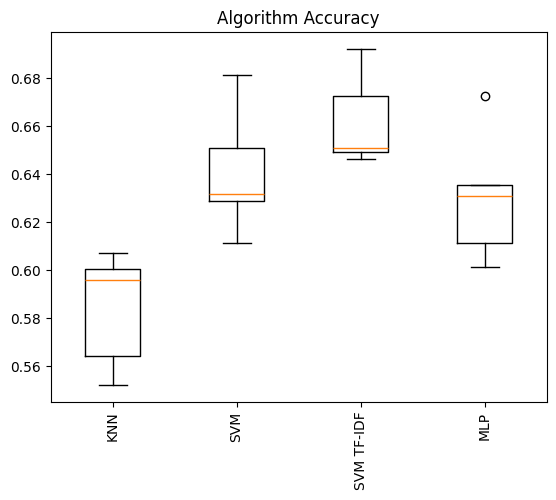

In [20]:
import matplotlib as plt

model_comp = []
model_comp.append(knn_score)
model_comp.append(svm_score)
model_comp.append(svm2_score)
model_comp.append(mlp_score)

fig, ax2 = plt.pyplot.subplots()
ax2.set_title('Algorithm Accuracy')
ax2.boxplot(model_comp)
ax2.set_xticklabels(['KNN', 'SVM', 'SVM TF-IDF', 'MLP'], rotation='vertical')

[Text(1, 0, 'KNN'),
 Text(2, 0, 'SVM'),
 Text(3, 0, 'SVM TF-IDF'),
 Text(4, 0, 'MLP')]

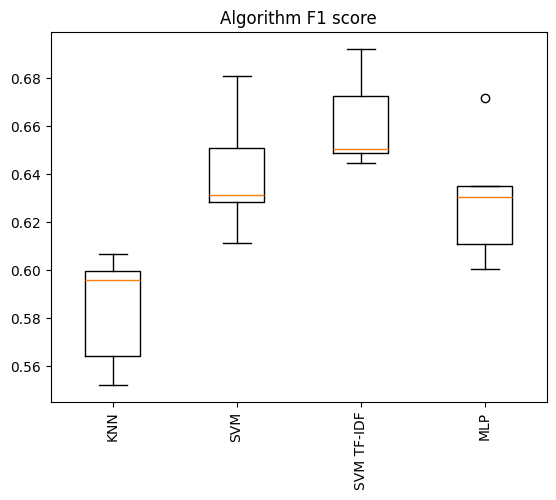

In [21]:
# Plot F1 scores

f1_scores_all = []
f1_scores_all.append(knn_f1_score)
f1_scores_all.append(svm_f1_score)
f1_scores_all.append(svm2_f1_score)
f1_scores_all.append(mlp_f1_score)

fig, ax2 = plt.pyplot.subplots()
ax2.set_title('Algorithm F1 score')
ax2.boxplot(f1_scores_all)
ax2.set_xticklabels(['KNN', 'SVM', 'SVM TF-IDF', 'MLP'], rotation='vertical')

In [22]:
# Compare predicted and real sentiments - analysis
# Just a visual check to see if there are any patterns (eg. certain types of titles are incorrectly classified...)
sentiment_labels = ['Negative', 'Neutral', 'Positive']
predicted_sentiments = [sentiment_labels[i] for i in svm_predictions]

df_results3 = pd.DataFrame({
    'title':  x_test['title'],
    'pair': pairs_encoder.inverse_transform(x_test['encoded_pair']),
    'pair_in_title': x_test['pair_in_title'],
    'predicted_sentiments': predicted_sentiments,
    'actual_sentiment': [sentiment_labels[i] for i in y_test.values]
})

df_results3.head(200)

,title,pair,pair_in_title,predicted_sentiments,actual_sentiment
4,EURCHF to head higher towards 10130 and projec...,EURCHF,1,Positive,Positive
10,EURCHF Still room to rise toward the 10500 are...,EURCHF,1,Positive,Positive
17,Rate differentials moving in favour of the EUR...,EURCHF,1,Positive,Positive
19,USDJPY trades between a key swing area between...,USDJPY,1,Neutral,Neutral
28,VIDEO: The aftermath of the US CPI.What levels...,USDJPY,1,Neutral,Neutral
...,...,...,...,...,...
920,AUDUSD 200DMA at 0678006850 likely to cap upsi...,AUDUSD,1,Positive,Negative
922,EURUSD Rebound could remain contained – SocGen,EURUSD,1,Positive,Neutral
940,GBPUSD dribbles around mid12100s as UK Budget ...,GBPUSD,1,Neutral,Neutral
942,AUDUSD looks set to regain 06700 despite mixed...,AUDUSD,1,Neutral,Positive


Confusion Matrix:


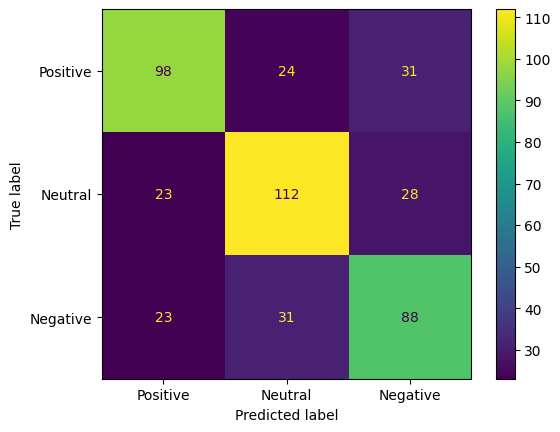

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix

y_true = df_results3['actual_sentiment']
y_pred = df_results3['predicted_sentiments']


labels = ["Positive", "Neutral", "Negative"]

cm = confusion_matrix(y_true, y_pred, labels=labels)

print("Confusion Matrix:")
#print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
